In [ ]:
# import sys, os
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/cdr')

In [1]:
import os

db = 'snorkel_good4.db'

if db:
    if db.endswith('.db'):
        os.system('cp {} snorkel.db'.format(db))
        print("Sqlite database {} copied".format(db))
    else:
        os.environ['SNORKELDB'] = 'postgres://localhost:5432/' + db
        print("Postgres database {} connected".format(db))
else:
    print("Using sqlite.db".format(db))
    
from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import snorkel_postgres
if not db.endswith('db') and not snorkel_postgres:
    raise Exception("Connection to PostgreSQL failed")

Sqlite database snorkel_good4.db copied


In [2]:
from snorkel.semantic import configuration

config = configuration
config['source'] = 'py'
config['parallelism'] = 1
config['beam_width'] = 10
config['paraphrases'] = False
config['filter_redundant_signatures'] = True
config['filter_uniform_labels'] = True
config['majority_vote'] = True
config['model_dep'] = False
config['n_epochs'] = 50
config['n_search'] = 10

In [3]:
from snorkel.models import candidate_subclass
ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

In [4]:
from snorkel.semantic import CDRModel
sm = CDRModel(session, ChemicalDisease, config)

In [ ]:
%time sm.parse()

In [ ]:
%time sm.extract()

In [ ]:
%time sm.load_gold()

In [ ]:
%time sm.featurize()

In [5]:
%time sm.generate_lfs()

Using 30 LFs
CPU times: user 17.4 s, sys: 296 ms, total: 17.7 s
Wall time: 17.7 s


In [6]:
%time sm.label()

Clearing existing...
Running UDF...
[========================================] 100%

Labeled split 0: (8272,30) sparse (nnz = 22537)
LF Summary Statistics: 30 LFs applied to 8272 candidates
------------------------------------------------------------
Coverage (candidates w/ > 0 labels):		94.09%
Overlap (candidates w/ > 1 labels):		76.32%
Conflict (candidates w/ conflicting labels):	54.58%
Redundancy (labels per candidate (avg)):	2.7
Clearing existing...
Running UDF...
[========================================] 100%

Labeled split 1: (888,30) sparse (nnz = 2398)
LF Summary Statistics: 30 LFs applied to 888 candidates
------------------------------------------------------------
Coverage (candidates w/ > 0 labels):		90.43%
Overlap (candidates w/ > 1 labels):		75.00%
Conflict (candidates w/ conflicting labels):	53.15%
Redundancy (labels per candidate (avg)):	2.7
CPU times: user 54.2 s, sys: 337 ms, total: 54.5 s
Wall time: 54.4 s


In [7]:
%time sm.supervise()

Saved 8272 training marginals
CPU times: user 5.01 s, sys: 116 ms, total: 5.12 s
Wall time: 5.13 s


Initialized RandomSearch search of size 10. Search space size = 100.

Random Search:
[0] Testing lr = 1.00e-05, l1_penalty = 1.00e-04, l2_penalty = 1.00e-06
[SparseLR] lr=1e-05 l1=0.0001 l2=1e-06
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=7020  #epochs=50  batch size=100
[SparseLR] Epoch 0 (1.94s)	Avg. loss=0.691511	NNZ=122840
[SparseLR] Epoch 5 (11.10s)	Avg. loss=0.681090	NNZ=122840
[SparseLR] Epoch 10 (20.73s)	Avg. loss=0.671647	NNZ=122840
[SparseLR] Epoch 15 (30.60s)	Avg. loss=0.663085	NNZ=122840
[SparseLR] Epoch 20 (40.01s)	Avg. loss=0.655240	NNZ=122840
[SparseLR] Epoch 25 (49.62s)	Avg. loss=0.647981	NNZ=122840
[SparseLR] Epoch 30 (59.10s)	Avg. loss=0.641209	NNZ=122840
[SparseLR] Epoch 35 (68.63s)	Avg. loss=0.634849	NNZ=122840
[SparseLR] Epoch 40 (78.12s)	Avg. loss=0.628842	NNZ=122840
[SparseLR] Epoch 45 (87.76s)	Avg. loss=0.623144	NNZ=122840
[SparseLR] Epoch 49 (95.47s)	Avg. loss=0.618783	NNZ=122840
[SparseLR] Training done (95.47s)
P: 0.470, R: 0.503

/Users/bradenjh/anaconda/envs/snorkel/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/bradenjh/anaconda/envs/snorkel/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


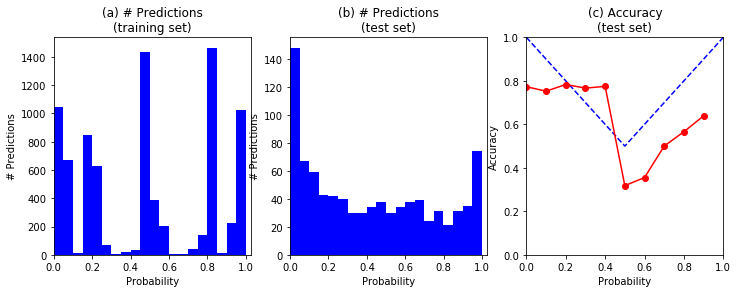

CPU times: user 21min 7s, sys: 2min 5s, total: 23min 12s
Wall time: 16min 30s


In [5]:
%time sm.classify()

In [6]:
from snorkel.annotations import load_gold_labels, load_marginals

TRAIN = 0
DEV = 1
TEST = 2

L_gold_dev = load_gold_labels(sm.session, annotator_name='gold', split=DEV)
L_gold_test = load_gold_labels(sm.session, annotator_name='gold', split=TEST)

featurizer = sm.featurizer
F_dev =  featurizer.load_matrix(sm.session, split=DEV)
F_test =  featurizer.load_matrix(sm.session, split=TEST)

train_marginals = load_marginals(sm.session, split=TRAIN)

Scores (Un-adjusted)
Pos. class accuracy: 0.588
Neg. class accuracy: 0.691
Precision            0.487
Recall               0.588
F1                   0.533
----------------------------------------
TP: 174 | FP: 183 | TN: 409 | FN: 122


Calibration plot:


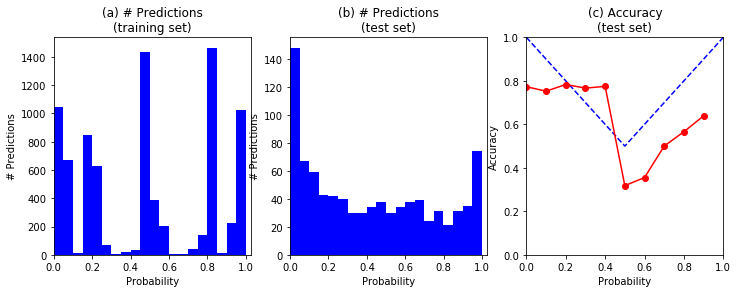

Scores (Un-adjusted)
Pos. class accuracy: 0.626
Neg. class accuracy: 0.669
Precision            0.477
Recall               0.626
F1                   0.542
----------------------------------------
TP: 942 | FP: 1032 | TN: 2083 | FN: 563


Calibration plot:


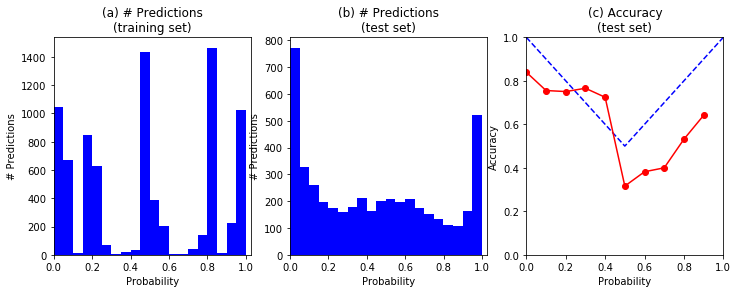

In [7]:
TP, FP, TN, FN = sm.model.score(sm.session, F_dev, L_gold_dev, train_marginals=train_marginals)

_, _, _, _ = sm.model.score(sm.session, F_test, L_gold_test, train_marginals=train_marginals)